In [313]:
import numpy as np
import pandas as pd
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
from scipy import stats
import warnings
from pyvinecopulib import Bicop, BicopFamily
from numpy.linalg import eigvals
from matplotlib import pyplot as plt
from scipy.stats import spearmanr

In [314]:
tickers = {
    "BTC": "BTC-USD",
    "ETH": "ETH-USD",
    "NIFTY50": "^NSEI",
    "DXY": "UUP",
    "TNX": "^TNX"
}

df = yf.download(list(tickers.values()), start="2018-12-01", end="2024-12-31")["Close"]
df.dropna(inplace=True)
df.columns = list(tickers.keys())
returns = np.log(df).diff().dropna()

port_ret = returns.mean(axis=1)
port_val = (1 + port_ret).cumprod()
future_15d_drawdown = port_val[::-1].rolling(30).max()[::-1].dropna()


alpha = 0.05


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\1594919515.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(list(tickers.values()), start="2018-12-01", end="2024-12-31")["Close"]
[*********************100%***********************]  5 of 5 completed


In [315]:
future_15d_drawdown

Date
2018-12-04    1.040378
2018-12-06    1.040378
2018-12-07    1.040378
2018-12-10    1.040378
2018-12-11    1.040378
                ...   
2024-11-07    3.820125
2024-11-08    3.820125
2024-11-11    3.820125
2024-11-12    3.820125
2024-11-13    3.820125
Length: 1423, dtype: float64

In [316]:
returns

,BTC,ETH,NIFTY50,DXY,TNX
Date,,,,,
2018-12-04,0.015989,0.011766,-0.001930,-0.001310,-0.022990
2018-12-06,-0.116685,-0.183238,-0.000386,-0.024998,-0.016552
2018-12-07,-0.029152,0.016574,-0.002710,0.008692,-0.009081
2018-12-10,0.023899,-0.017396,0.006567,-0.019380,0.002103
2018-12-11,-0.022540,-0.030344,0.002692,0.005771,0.008021
...,...,...,...,...,...
2024-12-23,-0.031905,-0.016483,0.003660,0.007011,0.016442
2024-12-24,0.041274,0.022081,0.002728,-0.001087,-0.001741
2024-12-26,-0.029627,-0.047149,-0.002045,0.000950,-0.002617


In [317]:
#probability integrity transform
def pseudo_obs(series):
    r = stats.rankdata(series, method="average")
    return r / (len(series) + 1.0)

U = returns.apply(pseudo_obs, axis=0)

In [318]:
def spectral_radius(W):
    A = (W + W.T) / 2.0
    eigs = eigvals(A)
    return float(np.max(eigs.real))

In [319]:
spectral_radii_series = []
drawdown = []

In [320]:
def fit_bb7_conditional_prob(u1, u2, alpha=0.05, mc_N=20000, family_force='bb7'):
    """
    Fit BB7 to (u1,u2) pseudo-observations (numpy arrays).
    Returns conditional probability p = C(alpha,alpha)/alpha.
    If BB7 fit fails, falls back to Bicop.select over families and uses best model.
    """
    # Prepare input for pyvinecopulib: n x 2 numpy array
    data = np.column_stack([u1, u2]).astype(float)

    # small input checks
    if data.shape[0] < 50:
        # Not enough data for stable BB7 fit
        warnings.warn("Fitting on small sample (<50). Estimates may be noisy.")
    # Clip to (0,1) to avoid edge numerical problems
    data = np.clip(data, 1e-8, 1 - 1e-8)

    # Try to instantiate a BB7 bicop and fit with MLE
    try:
        # Bicop.from_family accepts family identifier; we can use BicopFamily.bb7 or string 'bb7'
        # Note: you can also set rotate=0 if you want no rotation
        bicop = Bicop.from_family("bb7")   # family 'bb7' (Joe-Clayton / BB7)
        bicop.fit(data)  # MLE fit (default controls)
    except Exception as e:
        # fallback: try to select best family automatically (this will try multiple families)
        warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
        bicop = Bicop.from_data(data)  # this will select/fit automatically with default controls
        try:
            bicop.select(data)  # explicit selection (family search)
        except Exception:
            # if select fails, keep the bicop fitted from from_data()
            pass

    # Evaluate C(alpha, alpha) using bicop.cdf
    u_query = np.array([[alpha, alpha]], dtype=float)
    try:
        # bicop.cdf returns a 1d array; use mc_N quasi MC samples for numerical integration if required
        C_aa = float(bicop.cdf(u_query, N=mc_N)[0])
    except Exception as e:
        # As a last resort, approximate C(u,u) by empirical count (consistent fallback)
        warnings.warn(f"bicop.cdf failed, using empirical fallback for C({alpha},{alpha}). Reason: {e}")
        mask = (u1 < alpha) & (u2 < alpha)
        C_aa = mask.sum() / len(u1)

    # compute conditional probability p = C(alpha,alpha)/alpha
    p = C_aa / alpha
    # Force [0,1] range numerically
    p = float(np.clip(p, 0.0, 1.0))

    # also return family name for diagnostics
    fam = bicop.family.name if hasattr(bicop.family, 'name') else str(bicop.family)
    return p, C_aa, fam

In [321]:
window_size = 90
for i in range(window_size, len(df) + 1, 30):
    sample = df.iloc[i - window_size:i]
    drawdown.append(future_15d_drawdown.iloc[i])
    print(future_15d_drawdown.iloc[i])

    U = sample.apply(pseudo_obs, axis=0)
    assets = U.columns.tolist()
    n = len(assets)
    alpha = 0.05
    W = pd.DataFrame(np.zeros((n, n)), index=assets, columns=assets)
    family_matrix = pd.DataFrame("", index=assets, columns=assets)

    for i_idx, i in enumerate(assets):
        for j_idx, j in enumerate(assets):
            if i == j:
                continue
            u_i = U.iloc[:, i_idx].to_numpy()
            u_j = U.iloc[:, j_idx].to_numpy()
            p, C_aa, fam = fit_bb7_conditional_prob(u_i, u_j, alpha=alpha, mc_N=5000)
            W.loc[i, j] = p
            family_matrix.loc[i, j] = fam
    
    spectral_radii_series.append(spectral_radius(W))

C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")


1.3370663139165073


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: pyvinecopulib.Bicop, ndarray, kwargs = { N: int }
  warnings.warn(f"bicop.cdf failed, using empirical fallback for C({alpha},{alpha}). Reason: {e}")


1.471197902372557


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

1.268870869352283


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

1.2246574041455618


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

1.1956084949201171


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

1.1542503680082785


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

1.2741939527687256


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

0.8252542959694052


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

0.9622984177057852


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

0.9194092535115366


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

1.089649894091907


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

1.072467898035127


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

1.3579597982713727


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

1.8844914691624903


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.2904926850070257


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.5067220230536904


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.7342150693227745


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.292405085489779


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.555854463931317


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.8710685537103866


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.9094798273283433


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.6856563981941792


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.5779878732761747


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.7675672233887236


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.670360254714005


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.2799729391572585


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.196522732663959


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.185268641614681


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.2469303131550276


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.0974888714968287


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.232056563181028


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.373734692733544


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.334609534464642


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.434116603320066


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.4231059492218416


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.4573281489707504


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.78332512781543


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

2.871957288438531


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

3.461512545512004


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

3.464300119530856


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

3.466670944348545


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

3.3829110556696063


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

3.2955252540064492


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

3.185447745629786


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

3.731017371615242


C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_148228\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

IndexError: single positional indexer is out-of-bounds

Text(0, 0.5, 'Maximum Short-term Drawdown')

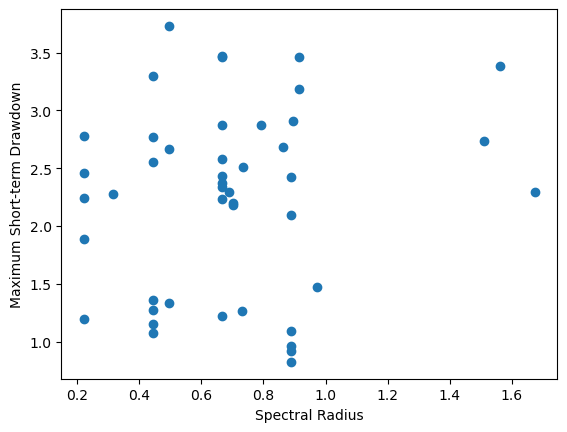

In [330]:
plt.scatter(spectral_radii_series, drawdown)
plt.xlabel("Spectral Radius")
plt.ylabel("Maximum Short-term Drawdown")

In [326]:
np.corrcoef(spectral_radii_series, drawdown)[0, 1]

0.13073218683805865

In [328]:
rho, pval = spearmanr(spectral_radii_series, drawdown)
print("Spearman correlation:", rho)
print("p-value:", pval)

Spearman correlation: 0.08102676445228008
p-value: 0.5967222177423764
